In [14]:
print("""
 This script creates a model using Logistic Regression to predict whether a 
 credit card transaction is fraudulent or not.
 
 Transactions are classified as:
 Rejected = P >= 80%
 Approved = P <= 60%
 Review   = 60% < P < 80%
 
 Author: Fernando Rodrigues Jr
 Date  : 07/02/2018
""")


 This script creates a model using Logistic Regression to predict whether a 
 credit card transaction is fraudulent or not.
 
 Transactions are classified as:
 Rejected = P >= 80%
 Approved = P <= 60%
 Review   = 60% < P < 80%
 
 Author: Fernando Rodrigues Jr
 Date  : 07/02/2018



In [16]:
import pandas as pd                                             # data handler
import numpy as np                                              # array handler
import matplotlib.pyplot as plt                                 # plot engine
import pickle                                                   # saving / load model
from IPython.display import display                             # display tool
from sklearn import preprocessing, cross_validation             # split data into test and train
from sklearn.linear_model import LogisticRegression             # fit / inference using logistic regression
from sklearn.metrics import roc_auc_score, roc_curve            # calculates AUC given a probability set

In [17]:
# Read CSV data
dataframe = pd.read_csv('dataset_com_grupo_de_teste.csv')

# Remove unused features
dataframe = dataframe.drop(['order_id', 'f25', 'f54', 'f55', 'f58', 'f161', 'f477', 'store_id', 'epoch'], axis=1)

# Start dealing with NaN's (replace NaN's by column's mean value)
data2NaNFilter  = dataframe.drop(['y'],1) # skip y column
dataNaNFiltered = data2NaNFilter.fillna(dataframe.mean(),inplace=True) #replace NaN's by column mean value
dataNaNFiltered['y'] = dataframe['y'] # reinsert y column

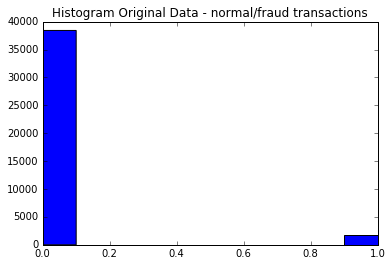

In [18]:
# Spliting data among annotated / non-annotated (no labels)
annotatedSet     = dataNaNFiltered.loc[dataframe['y'].notnull()]     # select only annotated y data
notAnnotatedSet  = dataNaNFiltered.loc[dataframe['y'].isnull()]      # select only NOT annotated y data

# Ploting y data histogram 
plt.figure()
plt.title("Histogram Original Data - normal/fraud transactions")
plt.hist(annotatedSet['y'])
plt.show()

In [19]:
# Spliting dataset into features / labels
X = np.array(annotatedSet.drop(['y'],1)) # Select features only
y = np.array(annotatedSet['y'])          # Select labels only

# Scalling features to speed-up gradient descent convergence
X_scaled = preprocessing.scale(X)

# Spliting annotated data in train (80%) / test (20%)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_scaled, y, test_size=0.2)

In [20]:
# Train a Logistic Regression classifier
clf = LogisticRegression(C=1e5, tol=1.0)
clf.fit(X_train, y_train)

# Dump the classifier to use later
with open('logisticRegression.pickle', 'wb') as f:
    pickle.dump(clf, f)

Accuracy Score:0.971983563691
AUC Score:0.913238511186


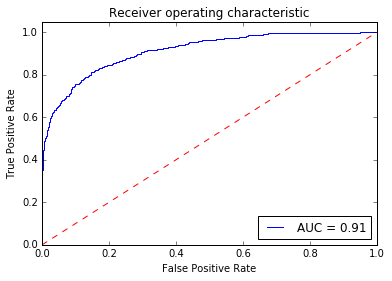

In [7]:
# Check model accuracy
accuracy = clf.score(X_test, y_test)
print("Accuracy Score:%s" % str(accuracy))

# Calculates prababilities from X_test features
probs = clf.predict_proba(np.array(X_test))[:, 1]

# Calculate AUC Score
auc_score = roc_auc_score(np.array(y_test), np.array(probs))
print("AUC Score:%s" % str(auc_score))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(np.array(y_test), np.array(probs))
plt.figure()
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% auc_score)
plt.legend(loc='lower right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.show()

In [8]:
# Testing data
# Predict lbl and probability in non-annotated data using the trained classifier
testNonAnnotated = notAnnotatedSet.drop(['y'],1)                       # exclude y column
testNonAnnotatedScaled = preprocessing.scale(testNonAnnotated)         # scale features

predictLbl     = clf.predict(np.array(testNonAnnotatedScaled))         # classfy data in 0(normal) and 1(fraud)
predictionProb = clf.predict_proba(np.array(testNonAnnotatedScaled))   # predict probabilities

# Insert values in the dataframe
testNonAnnotated['y']    = predictLbl                       
testNonAnnotated['prob'] = predictionProb[:,0]

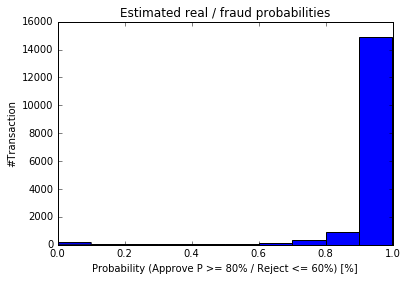

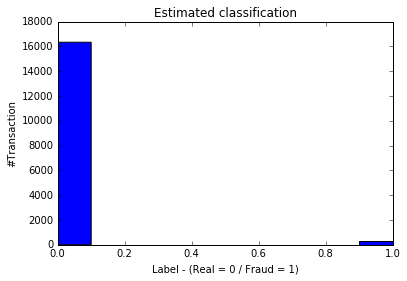

In [9]:
# Ploting probability results
plt.figure()
plt.hist(predictionProb[:,0])
plt.xlabel('Probability (Approve P >= 80% / Reject <= 60%) [%]') 
plt.ylabel('#Transaction')
plt.title('Estimated real / fraud probabilities')
plt.show()

# Ploting classification result
plt.figure()
plt.hist(predictLbl)
plt.xlabel('Label - (Real = 0 / Fraud = 1)')
plt.ylabel('#Transaction')
plt.title('Estimated classification')
plt.show()

In [10]:
# Set label according to estimated probabilities
minRejectProb = 0.6
minApproveProb = 0.8 
testNonAnnotated.loc[(testNonAnnotated['prob'] <=  minRejectProb),'label'] = 'rejected'
testNonAnnotated.loc[(testNonAnnotated['prob'] >= minApproveProb),'label'] = 'approved'
testNonAnnotated.loc[(testNonAnnotated['prob'] >  minRejectProb) & (testNonAnnotated['prob'] < minApproveProb),'label'] = 'review'

lenApproved = len(testNonAnnotated.loc[(testNonAnnotated['label'] == 'approved')])
print("#Transaction approved: %s" % str(lenApproved))

lenRejected = len(testNonAnnotated.loc[(testNonAnnotated['label'] == 'rejected')])
print("#Transaction rejected: %s" % str(lenRejected))

lenReview = len(testNonAnnotated.loc[(testNonAnnotated['label'] == 'review')])
print("#Transaction under review: %s" % str(lenReview))

#Transaction approved: 15852
#Transaction rejected: 363
#Transaction under review: 429


In [11]:
# Show some data from Dataframe with inserted probablities, y and labels
display((testNonAnnotated[['y', 'prob', 'label']]).head(1000))

,y,prob,label
40151,0.0,0.988849,approved
40152,0.0,0.982631,approved
40153,0.0,0.935870,approved
40154,0.0,0.920988,approved
40155,0.0,0.916039,approved
40156,0.0,0.984825,approved
40157,0.0,0.943741,approved
40158,0.0,0.958706,approved
40159,0.0,0.969695,approved
40160,0.0,0.908524,approved
